"Geo Data Science with Python" 
### Notebook Lesson 9

# Using Machine Learning for Geo Data Analyses

---

In [7]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt


# TOS Data & SVD

First we load the dataset:

In [2]:

data = Dataset('./tos_O1_2001-2002.nc')
lat = data.variables['lat'][:].data
lon = data.variables['lon'][:].data
time = data.variables['time'][:].data
tos = data.variables['tos'][:].data
tos = tos -  273.15; # convert unit to Celcius
mask = tos>=1e20
mask_flat = mask[0,:,:].flatten()
tos[tos>=1e20] = 0   # set missing values to 0
data.close()

In [3]:
tos.shape

(24, 170, 180)

Now we want to use SVD/PCA for the spatio-temporal TOS dataset, hence, we want to include all 24 maps measured over 2 years and analyze dominant spatial and temporal patterns in the data. For that we have to reshape our `tos` 3D-array into a `X` 2D-array that contains each map reshaped into a vector on one dimension, and time on the other dimension.

In [4]:
lenLon = len(lon)
lenLat = len(lat)
X = tos.reshape((24,lenLon*lenLat))
X = np.transpose(X)
X.shape


(30600, 24)

We can test if our reshaping works as planned, by retrieving the first row and reshaping it back into a global map and plotting it.

In [8]:
tos1 = X[:,0].reshape((lenLat,lenLon))
tos1.shape

(170, 180)

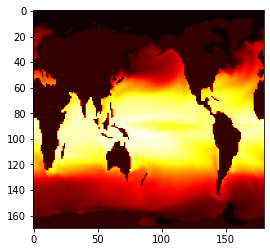

In [9]:
img = plt.imshow(np.flipud(tos1),cmap = 'hot')

The fact, that we see the continents (our no-data pixel), means our reshaping works as planned.

In the next step we want to perform a SVD/PCA with the reshaped matrix `X`, in a way to extract spatial patterns in the data.

In [10]:
u,s,vT = np.linalg.svd(X,full_matrices=0)

In [11]:
u.shape

(30600, 24)

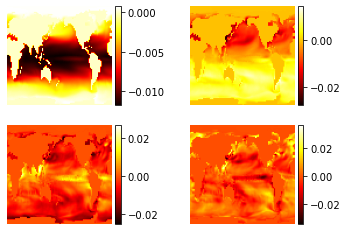

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)  # reshapes 2d axes array into a 1d array (for easier indexing)
for j in range(4):
    U = np.flipud(np.reshape(u[:,j],(lenLat,lenLon)))
    U2 = U[::2,::2]  # get only every second pixel, for smaller image size
    im = axs[j].imshow(U2,cmap='hot')
    axs[j].axis('off')
    # following lines add colorbar to each subplot
    divider = make_axes_locatable(axs[j])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical');


In [13]:
vT.shape

(24, 24)

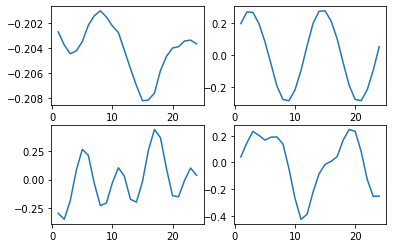

In [14]:
fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)
for j in range(4):
    V = vT[j,:]
    im = axs[j].plot(range(1,len(V)+1),V)


For comparison, the time series of the global mean tos looks like this:

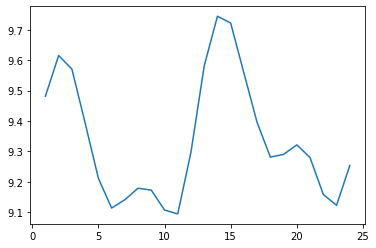

In [15]:
fig = plt.subplots(1)
im = plt.plot(range(1,25),np.mean(X,0))

The singular values contain energy of the signal components. From the following plot, we can see that the first 5 components explain almost 95% of the `tos` signal.

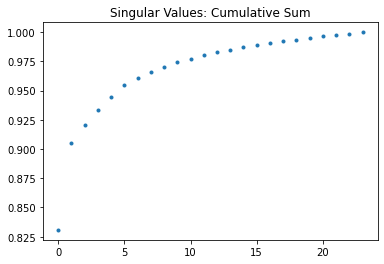

In [16]:
plt.figure()
plt.plot(np.cumsum(s)/np.sum(s),'.')
plt.title('Singular Values: Cumulative Sum')
plt.show()

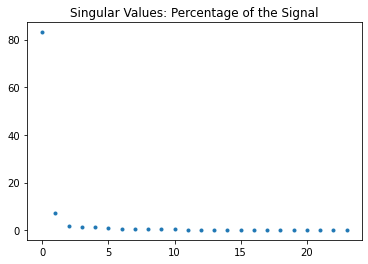

In [17]:
plt.figure()
plt.plot(s/np.sum(s)*100,'.')
plt.title('Singular Values: Percentage of the Signal')
plt.show()

---
# Analyzing the SVD output: reconstructing specific components

In [18]:
u,s,vT = np.linalg.svd(X,full_matrices=0)

In [19]:
nMC = 5  # major components that will be reconstructed
recon = u[:,nMC-1:nMC] @ np.diag(s[nMC-1:nMC])@vT[nMC-1:nMC,:]  # reconstruct time series X_r = U_r*sigma_r*V_r
recon.shape

(30600, 24)

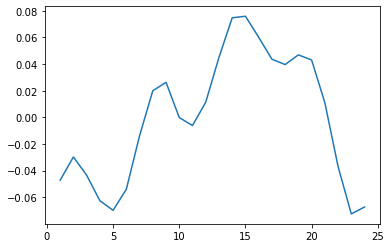

In [20]:
# Plotting the global mean of the major component (land areas removed)
fig = plt.subplots(1)
im = plt.plot(range(1,25),np.mean(recon[~mask_flat,:],0))

In [21]:
recon.shape

(30600, 24)

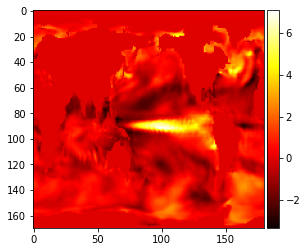

In [22]:
#  reconstructed certain feature with units: T = U*Sigma
nMC = 5
T = u[:,nMC-1:nMC] @ np.diag(s[nMC-1:nMC])
Tplot = np.flipud(np.reshape(T[:,0],(lenLat,lenLon)))

fig,axs = plt.subplots(1,1)
im = plt.imshow(Tplot,cmap='hot')
fig.colorbar(im, cax=cax, orientation='vertical');
# following lines add colorbar to each subplot
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

# Using SVD features for Cluster Analysis

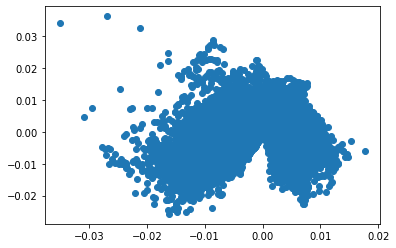

In [23]:
# Scatter plot main features against each other
nMCa = 2
nMCb = 3
u_Oc = u[~mask_flat,:]
plt.scatter(u_Oc[:,nMCa-1:nMCa] , u_Oc[:,nMCb-1:nMCb] )

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


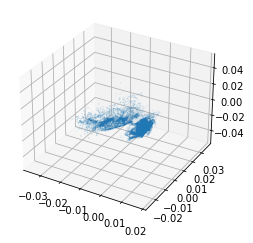

In [24]:
# Scatter plot main features against each other
nMCa = 2
nMCb = 3
nMCc = 4
u_Oc = u[~mask_flat,:]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

plt.scatter(u_Oc[:,nMCa-1:nMCa] , u_Oc[:,nMCb-1:nMCb] , u_Oc[:,nMCc-1:nMCc] )

In [25]:
tos.shape


(24, 170, 180)

In [26]:
import numpy.matlib

lon_grid = np.transpose(np.matlib.repmat(lat,len(lon),1))
lon_flat = lon_grid.flatten()
lon_mask = lon_flat[mask_flat]
i_lonCut = int(max(np.argwhere(lon_mask == -0.5))+1)

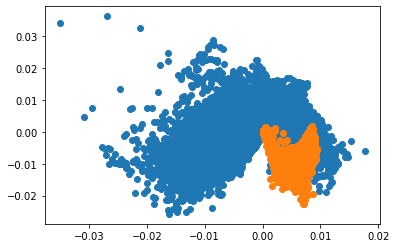

In [27]:
# Scatter plot main features against each other
nMCa = 2
nMCb = 3
u_Oc = u[~mask_flat,:]
plt.scatter(u_Oc[i_lonCut:,nMCa-1:nMCa] , u_Oc[i_lonCut:,nMCb-1:nMCb] ) # northern Hemisphere
plt.scatter(u_Oc[0:i_lonCut,nMCa-1:nMCa] , u_Oc[0:i_lonCut,nMCb-1:nMCb] ) # southern Hemisphere


... to be continued next class (this notebook will be updated before next class)

# Regression Example